In [36]:
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import json, zipfile, itertools

In [37]:
sim_id = 2

In [38]:
def merge_dict(list_of_dicts):
    return {key: [d[key] for d in list_of_dicts] for key in list_of_dicts[0]}

def read_results(sim_id, method):
    results = {}
    with zipfile.ZipFile(f'results/sim{sim_id}.zip', 'r') as zip_ref:
        file_names = zip_ref.namelist()
        for file_name in file_names[1:]:
            mtd, snr, job_id = file_name.split('_')
            if '/' in mtd:
                mtd = mtd.split('/')[1]
            if mtd == method:
                with zip_ref.open(file_name, "r") as file:
                    if snr not in results:
                        results[snr] = []
                    results[snr].append(json.load(file))
    results = {k: merge_dict(v) for k, v in results.items()}
    results_mean = {k: {k1: np.mean(v1, axis=0) for k1, v1 in v.items()} for k, v in results.items()}
    results_sd = {k: {k1: np.std(v1, axis=0) for k1, v1 in v.items()} for k, v in results.items()}
    return results_mean, results_sd

def merge_methods(results_lst):
    keys1 = list(results_lst[0].keys())
    keys2 = list(results_lst[0][keys1[0]].keys())
    results_merged = {k1: {k2: None for k2 in keys2} for k1 in keys1}
    for k1 in keys1:
        for k2 in keys2:
            x = [results[k1][k2] for results in results_lst]
            results_merged[k1][k2] = np.concatenate(x)
    return results_merged

# Accuracy and BCI-Utility over # FS Seqs

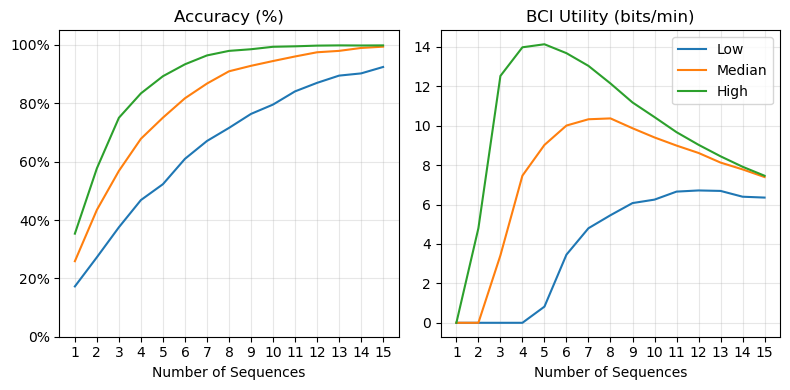

In [39]:
results_fs_mean, results_fs_sd = read_results(sim_id, 'fs')
#
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
x = np.arange(1, 16)
for mu1, label in zip(['0.9', '1.2', '1.5'], ['Low', 'Median', 'High']):
    axes[0].plot(x, results_fs_mean[mu1]['accu'], label=label)
    axes[1].plot(x, np.maximum(results_fs_mean[mu1]['util'], 0), label=label)
axes[1].legend()
axes[0].set_title('Accuracy (%)')
axes[0].set_ylim(0, 1.05) 
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
axes[1].set_title('BCI Utility (bits/min)')
for ax in axes:
    ax.grid(True, alpha=0.3)
    ax.set_xticks(x)
    ax.set_xlabel('Number of Sequences')
fig.tight_layout()
fig.savefig(f'results/sim{sim_id}_fs.pdf')

# Determine optimal # Seqs for FSO

In [40]:
best_id = {k: v['util'].argmax() for k, v in results_fs_mean.items()}
print({k: v+1 for k, v in best_id.items()})
results_fs_mean = {k: {k1: v1[[id, 14]] for k1, v1 in results_fs_mean[k].items()} for k, id in best_id.items()}
results_fs_sd = {k: {k1: v1[[id, 14]] for k1, v1 in results_fs_sd[k].items()} for k, id in best_id.items()}

{'0.9': 12, '1.2': 8, '1.5': 5}


In [41]:
results_agree_mean, results_agree_sd = read_results(sim_id, 'agree')
results_acrs_mean, results_acrs_sd = read_results(sim_id, 'acrs')

# Mean Performance

The table below presents the mean performance across three signal-to-noise ratios (SNRs): 0.9, 1.2, and 1.5, corresponding to Low, Median, and High levels, respectively. The columns represent results for the following methods: FSO, FSM, AGREE, AC, and AC+RS.

In [42]:
# merge_methods([results_fs_mean, results_agree_mean])
merge_methods([results_fs_mean, results_agree_mean, results_acrs_mean])

{'0.9': {'accu': array([0.87      , 0.9244    , 0.76684402, 0.8928    , 0.8776    ]),
  'util': array([ 6.717999  ,  6.35581814,  7.16016595,  8.17043346, 10.20997409]),
  'time': array([0.565     , 0.685     , 0.38371741, 0.49503067, 0.39179333])},
 '1.2': {'accu': array([0.9096    , 0.994     , 0.85555102, 0.89      , 0.8764    ]),
  'util': array([10.37508308,  7.39814835, 12.16406491, 12.98425509, 15.00132922]),
  'time': array([0.405     , 0.685     , 0.30001521, 0.30839867, 0.27385733])},
 '1.5': {'accu': array([0.8928, 0.9984, 0.8976, 0.9172, 0.9252]),
  'util': array([14.13882364,  7.46404279, 15.87903741, 17.74989262, 19.93983416]),
  'time': array([0.285     , 0.685     , 0.257016  , 0.24128933, 0.23670133])}}

#  Performance (SD) 

In [43]:
# merge_methods([results_fs_sd, results_agree_sd])
merge_methods([results_fs_sd, results_agree_sd, results_acrs_sd])

{'0.9': {'accu': array([0.03515679, 0.03628553, 0.06252052, 0.04845782, 0.10148024]),
  'util': array([0.63833322, 0.54341248, 1.74534826, 1.01397699, 2.72541211]),
  'time': array([2.22044605e-16, 2.22044605e-16, 1.57820545e-02, 4.37152243e-02,
         6.66064251e-02])},
 '1.2': {'accu': array([0.03883092, 0.01077033, 0.04852182, 0.05      , 0.12829279]),
  'util': array([0.98357904, 0.16129655, 1.64155573, 1.45545157, 3.78345001]),
  'time': array([3.88578059e-16, 2.22044605e-16, 1.20373838e-02, 2.27279974e-02,
         8.81858956e-02])},
 '1.5': {'accu': array([0.04190656, 0.00542586, 0.04169221, 0.03898923, 0.05150689]),
  'util': array([1.50842541, 0.08125779, 1.65582182, 1.38503834, 3.85017607]),
  'time': array([1.66533454e-16, 2.22044605e-16, 9.03006888e-03, 1.55546898e-02,
         1.13143982e-01])}}